In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from math import ceil
from datetime import datetime, timedelta

In [164]:
df = pd.read_csv('dataset_mood_smartphone.csv')

In [165]:
"""
Check stats on NaN values and Remove NaN values
"""
# df with NaN values
df_na = df[pd.isna(df['value'])]

# Counts NaN values for each variable
df_na_variables = df_na['variable'].value_counts()
df = df.dropna()

Outliers detected within each variable:
       Unnamed: 0       id                    time  variable       value  \
0           16944  AS14.01 2014-03-21 14:00:00.000  activity    0.725000   
1           16945  AS14.01 2014-03-21 15:00:00.000  activity    0.798387   
2           16955  AS14.01 2014-03-22 10:00:00.000  activity    0.508475   
3           16960  AS14.01 2014-03-22 15:00:00.000  activity    0.436975   
4           16961  AS14.01 2014-03-22 16:00:00.000  activity    0.508333   
...           ...      ...                     ...       ...         ...   
38116      136460  AS14.33 2014-05-30 21:17:40.377    screen  216.134000   
38117      136467  AS14.33 2014-05-30 21:38:25.263    screen  164.072000   
38118      136468  AS14.33 2014-05-30 21:47:30.344    screen  504.017000   
38119      136469  AS14.33 2014-05-30 21:58:51.355    screen  526.137000   
38120      136470  AS14.33 2014-05-30 22:18:11.591    screen  847.779000   

             date  hour  
0      2014-03-21    

In [166]:
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date
df['hour'] = df['time'].dt.hour
unique_variables = df['variable'].unique()
participants = df['id'].unique()
days = df['date'].unique()

In [198]:
"""
Detecting outliers with IQR
"""

# Function to detect outliers within a group
def detect_outliers(group):
    Q1 = group['value'].quantile(0.25)
    Q3 = group['value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Return only outliers within the group
    return group[(group['value'] < lower_bound) | (group['value'] > upper_bound)]

# Group by participant and apply the outlier detection
outliers_by_variable_df = df.groupby('variable').apply(detect_outliers).reset_index(drop=True)

# print("Outliers detected within each variable:")
# print(outliers_by_variable_df)

outliers_count_per_variable = outliers_by_variable_df.groupby('variable')['value'].count().reset_index(name='count')
print(outliers_count_per_variable)


                variable  count
0               activity   2223
1         appCat.builtin  10152
2   appCat.communication   6401
3   appCat.entertainment   4517
4         appCat.finance    118
5            appCat.game     85
6          appCat.office    848
7           appCat.other   1000
8          appCat.social   1838
9          appCat.travel    181
10        appCat.unknown     80
11      appCat.utilities    182
12        appCat.weather     10
13    circumplex.valence     31
14                  mood    400
15                screen  10055


In [167]:
active_subjects_hour = df.groupby(['hour'])['id'].unique().reset_index()

In [168]:
"""
Average data for each day:
"""
# non_time_variables = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity']
non_time_variables = ['mood', 'circumplex.arousal', 'circumplex.valence']
df_time = df[~df['variable'].isin(non_time_variables)]

# For time variables, we take the mean of each day averaged over the active participants of the corresponding day
daily_avg_df_time = df_time.groupby(['date', 'variable'])['value'].sum().reset_index()
daily_avg_df_time['value'] = daily_avg_df_time['value'] / len(active_subjects_day['date'])

# For non-time variables, we take the mean of all the inputs for each hour
df_non_time = df[df['variable'].isin(non_time_variables)]
daily_avg_df_non_time = df_non_time.groupby(['date', 'variable'])['value'].mean().reset_index()

# Merges the two dataframes
daily_avg_df = pd.concat([daily_avg_df_non_time, daily_avg_df_time], ignore_index=True)

In [169]:
"""
Stats on data
"""
print(f'Amount of measured variables: {len(unique_variables)}')
print(f'Amount of participants: {len(participants)}')
print(f'Experiment took place over {len(days)} days')
for variable in unique_variables:
    print(len(daily_avg_df['variable'] == variable))
print(daily_avg_df[daily_avg_df['variable'] == 'mood'])

Text(0.5, 1.0, 'Correlation Heatmap of Variables')

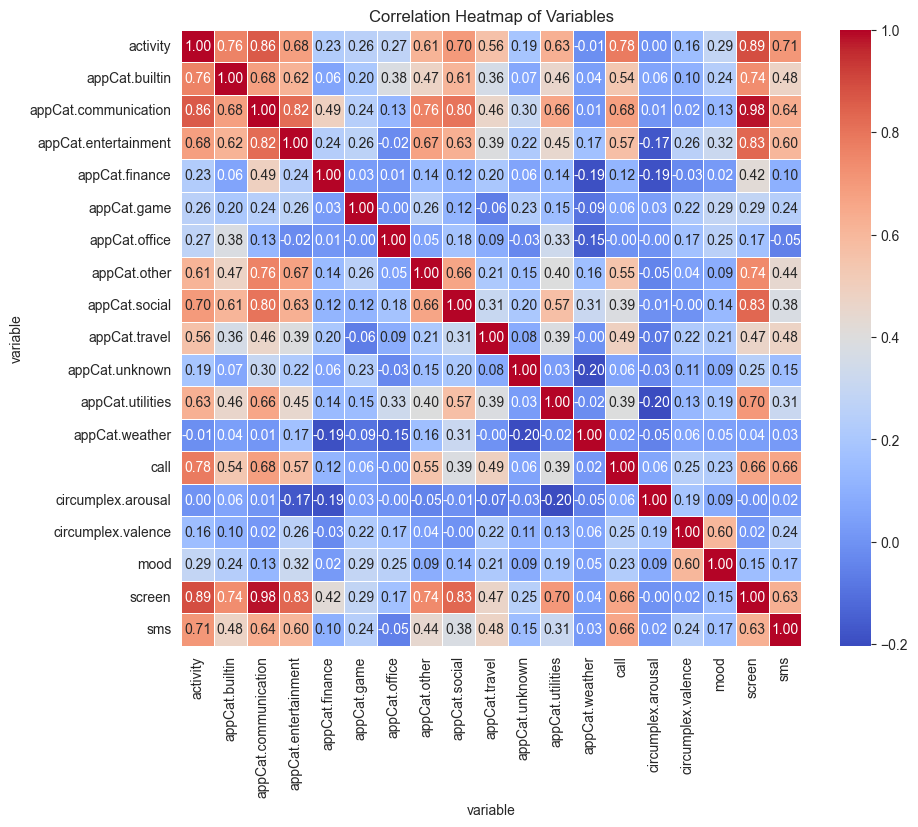

In [170]:
"""
Corr. heatmap, index on date
"""
df_pivoted = daily_avg_df.pivot_table(index='date', columns='variable', values='value')
corr_matrix = df_pivoted.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Variables')

In [171]:
"""
Average data for each hour
"""
non_time_variables = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity']
df_time = df[~df['variable'].isin(non_time_variables)]

# For time variables, we take the mean of each hour averaged over the active participants of the corresponding hour
hourly_avg_df_time = df_time.groupby(['hour', 'variable'])['value'].sum().reset_index()
hourly_avg_df_time['value'] = daily_avg_df_time['value'] / len(active_subjects_hour['hour'])

# For non-time variables, we take the mean of all the inputs of each day
df_non_time = df[df['variable'].isin(non_time_variables)]
hourly_avg_df_non_time = df_non_time.groupby(['hour', 'variable'])['value'].mean().reset_index()

# Merges the two dataframes
hourly_avg_df = pd.concat([hourly_avg_df_non_time, hourly_avg_df_time], ignore_index=True)

Text(0.5, 1.0, 'Correlation Heatmap of Variables')

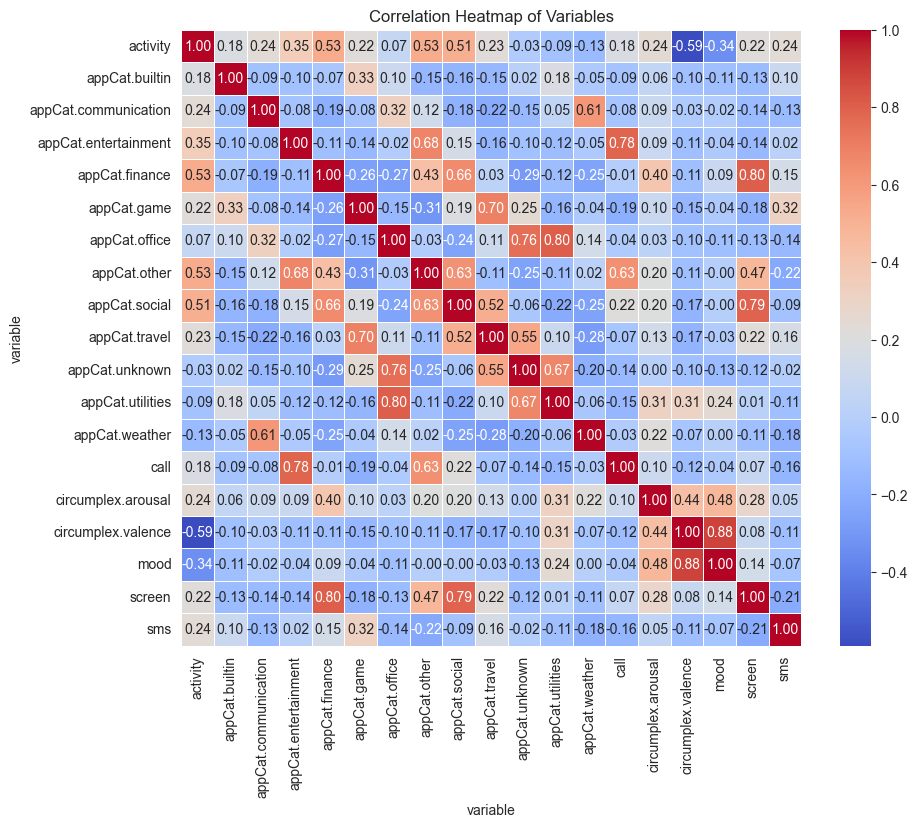

In [172]:
"""
Corr. heatmap, index on hour
"""
df_pivoted = hourly_avg_df.pivot_table(index='hour', columns='variable', values='value')
corr_matrix = df_pivoted.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Variables')

In [173]:
"""
Calculate end and start date of data collection on each variable
Conclusion: There are only 49 days of which between the latest starting date and the earliest stop date of measuring the predictors.
"""
start_dates = []
end_dates = []

for variable in unique_variables:
    var_df = df.loc[df['variable'] == variable]
    start_date = var_df['date'].min()
    start_dates.append(start_date)
    end_date = var_df['date'].max()
    end_dates.append(end_date)
    print(f'var: {variable}, start: {start_date}, end: {end_date}')

max_start_date = max(start_dates)
min_end_date = min(end_dates)

print('')
print(f'Latest start date: {max_start_date}, earliest end date: {min_end_date}')

var: mood, start: 2014-02-26, end: 2014-06-08
var: circumplex.arousal, start: 2014-02-26, end: 2014-06-08
var: circumplex.valence, start: 2014-02-26, end: 2014-06-08
var: activity, start: 2014-03-17, end: 2014-06-09
var: screen, start: 2014-03-13, end: 2014-06-08
var: call, start: 2014-02-17, end: 2014-06-06
var: sms, start: 2014-02-17, end: 2014-06-07
var: appCat.builtin, start: 2014-03-13, end: 2014-06-08
var: appCat.communication, start: 2014-03-13, end: 2014-06-08
var: appCat.entertainment, start: 2014-03-13, end: 2014-06-02
var: appCat.finance, start: 2014-03-15, end: 2014-05-09
var: appCat.game, start: 2014-03-20, end: 2014-05-13
var: appCat.office, start: 2014-03-15, end: 2014-05-28
var: appCat.other, start: 2014-03-13, end: 2014-06-08
var: appCat.social, start: 2014-03-13, end: 2014-06-08
var: appCat.travel, start: 2014-03-14, end: 2014-06-05
var: appCat.unknown, start: 2014-03-14, end: 2014-05-30
var: appCat.utilities, start: 2014-03-13, end: 2014-06-06
var: appCat.weather, st

In [174]:
# for variable in unique_variables:
#     print(len(hourly_avg_df['variable'] == variable))
# print(daily_avg_df[hourly_avg_df['variable'] == 'mood'])

In [189]:
"""
Calculate end and start date of data collection for each participant.
Conclusion: The amount of times in which mood is measured for the participants varies between 128 and 299 days. The timeframe in days in which mood was measured for each participant varies between 30 days and 67 days. 
"""
start_dates = []
end_dates = []

for participant in participants:
    mood_measurements = df[df['variable'] == 'mood']
    id_df = mood_measurements.loc[(df['id'] == participant)]
    start_date = id_df['date'].min()
    start_dates.append(start_date)
    end_date = id_df['date'].max()
    end_dates.append(end_date)
    print(f'id: {participant}, start: {start_date}, end: {end_date}, days: {end_date - start_date}, mood count = {len(id_df)}')

# max_start_date = max(start_dates)
# min_end_date = min(end_dates)

# print('')
# print(f'Latest start date: {max_start_date}, earliest end date: {min_end_date}')

id: AS14.01, start: 2014-02-26, end: 2014-05-04, days: 67 days, 0:00:00, mood count = 222
id: AS14.02, start: 2014-03-16, end: 2014-04-25, days: 40 days, 0:00:00, mood count = 159
id: AS14.03, start: 2014-03-21, end: 2014-05-07, days: 47 days, 0:00:00, mood count = 221
id: AS14.05, start: 2014-03-14, end: 2014-05-05, days: 52 days, 0:00:00, mood count = 241
id: AS14.06, start: 2014-03-24, end: 2014-05-08, days: 45 days, 0:00:00, mood count = 203
id: AS14.07, start: 2014-03-19, end: 2014-05-05, days: 47 days, 0:00:00, mood count = 192
id: AS14.08, start: 2014-03-05, end: 2014-05-05, days: 61 days, 0:00:00, mood count = 299
id: AS14.09, start: 2014-03-21, end: 2014-05-05, days: 45 days, 0:00:00, mood count = 197
id: AS14.12, start: 2014-03-15, end: 2014-05-05, days: 51 days, 0:00:00, mood count = 185
id: AS14.13, start: 2014-03-13, end: 2014-05-04, days: 52 days, 0:00:00, mood count = 244
id: AS14.14, start: 2014-03-20, end: 2014-05-05, days: 46 days, 0:00:00, mood count = 164
id: AS14.1